In [1]:
#透過角 を求めるための回転装置をもしたシミュレーション
#90度だけで良さそう
#全ての直線データをぶちこむ
#外周座標は最後の透過角を求めるために必要。
# import time

def light_receiving(gradient ,intercept, x_k, y_k, distance1, distance2, slit1, slit2):
    #print("値が入ってるか？",gradient[0],intercept[0],x_k[0],y_k[0],distance1,distance2)
#     t1 = time.time() 
    
    #まずslitの位置を定義 下準備
    #円管とスリットの距離の定義が必要
#     distance1 = 1
#     distance2 = 1
    i = 0
    x1y1 = np.zeros((900,2))
    x2y2 = np.zeros((900,2))
    s_sita = np.zeros(1801)
    for sita in [tmp*0.1 for tmp in range(900, 1800)]:
        x1 = distance1*np.cos(np.deg2rad(sita))
        y1 = distance1*np.sin(np.deg2rad(sita))
        x2 = distance2*np.cos(np.deg2rad(sita))
        y2 = distance2*np.sin(np.deg2rad(sita))
        similar_sita = abs(np.arctan(np.tan(abs(x1)/abs(y1))))
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        s_sita[i] = similar_sita
        i += 1
        
    # 経過時間を表示
#     t2 = time.time()
#     elapsed_time_1 = t2-t1
#     print(f"経過時間：{elapsed_time_1}","秒")
#     print("---------------下準備終了！------------------")
    
#     t3 = time.time() 
    #スリット幅を入力
    #need to change
#     slit1 = 1
#     slit2 = 1
    #ある角度における光線の本数カウント用
    count_light = [0] * 900
    count_x = [0] * 900
    count_y = [0] * 900
    t_angle = [0] * 900
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    
    for g, i, xk, yk in zip(gradient, intercept, x_k, y_k):
        for j in range(900): #90度分の回転を表す
            #スリットの傾きと,光線の交点
            a = -np.tan(s_sita[j])
            b = x1y1[j][1] - a*x1y1[j][0]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1*np.cos(abs(s_sita[j]))/2
            #1つ目のスリットを超えられるかどうか
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                b = x2y2[j][1] - a*x2y2[j][0]
                x = (i - b)/(a - g)
                s_d = slit2*np.cos(abs(s_sita[j]))/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += 1
                    #透過角算出用のx,yもおいておきたい→平均orとりあえずmin,maxの2つをキープしておいて考える。
                    #怪しい、場合によってはmaxminが大幅に離れてる？→ここはどのへんに値が偏っているのかを見てもいいかも一旦保留
                    count_x[j] += xk
                    count_y[j] += yk
    
    # 経過時間を表示
#     t4 = time.time()
#     elapsed_time_2 = t4-t3
#     print(f"経過時間：{elapsed_time_2}","秒")
#     print("---------------光線の処理完了！------------------")
#     print("スリット1枚目を超えられた本数",cnt_slit1)
#     print("スリット2枚目を超えられた本数",cnt_slit2)
    #print("光線の本数は？",sum(count_light))
    
#     t5 = time.time()
    #jごとの透過角を求める必要がある(横軸)
    for j in range(900):
        #ある角度jのときのスリットを透過する外周の点の平均
        if count_light[j] == 0:
            continue
        x_g = count_x[j]/count_light[j]
        y_g = count_y[j]/count_light[j]
        x_slit2 = x2y2[j][0]
        y_slit2 = x2y2[j][1]
        a = y_slit2 - y_g
        b = x_g - x_slit2
        c = 1
        d = 0
        t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
        
    # 経過時間を表示
#     t6 = time.time()
#     elapsed_time_3 = t6-t5
#     print(f"経過時間：{elapsed_time_3}","秒")
#     print("---------------透過角算出！------------------")
    
#     print("総実行時間:",(elapsed_time_1+elapsed_time_2+elapsed_time_3)/60,"分")
    
    
    return count_light, t_angle 

↓ 内径r_i = 100 外径r = 2000


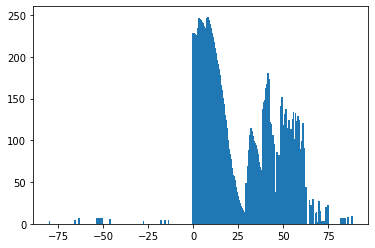

↓ 内径r_i = 200 外径r = 2000


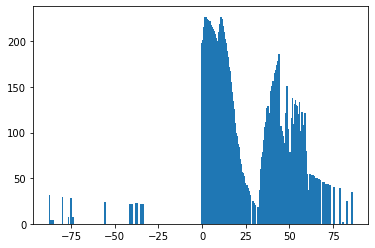

↓ 内径r_i = 300 外径r = 2000


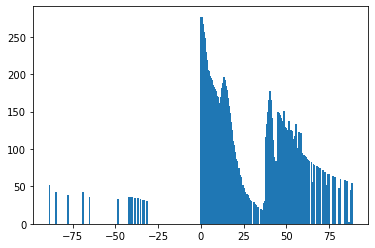

↓ 内径r_i = 400 外径r = 2000


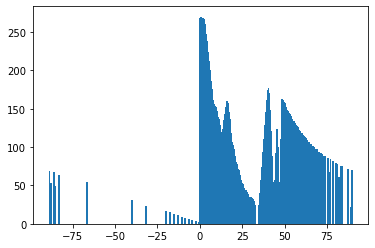

↓ 内径r_i = 500 外径r = 2000


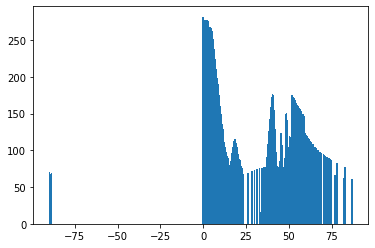

↓ 内径r_i = 600 外径r = 2000


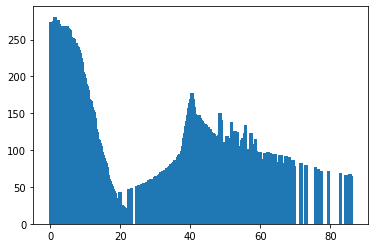

↓ 内径r_i = 700 外径r = 2000


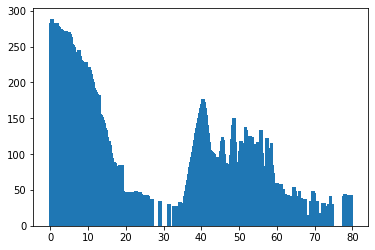

↓ 内径r_i = 800 外径r = 2000


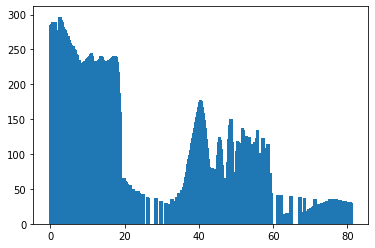

↓ 内径r_i = 900 外径r = 2000


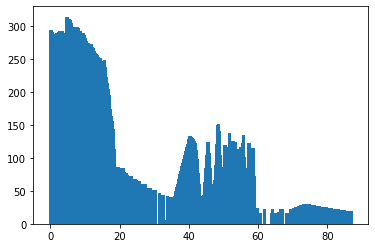

↓ 内径r_i = 1000 外径r = 2000


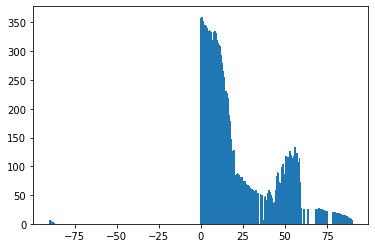

↓ 内径r_i = 1100 外径r = 2000


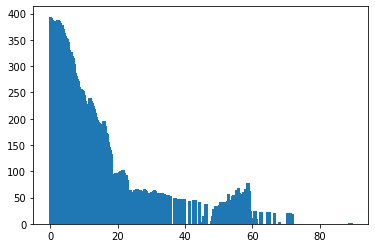

↓ 内径r_i = 1200 外径r = 2000


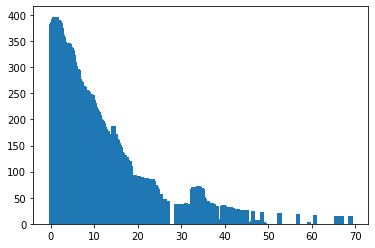

↓ 内径r_i = 1300 外径r = 2000


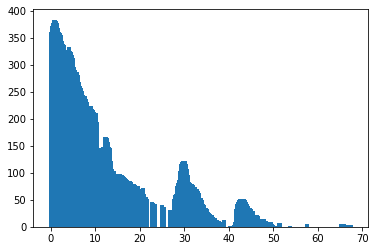

↓ 内径r_i = 1400 外径r = 2000


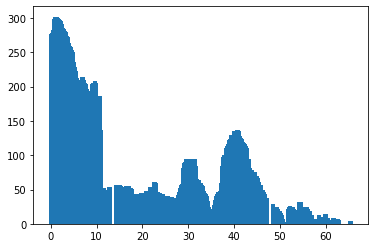

↓ 内径r_i = 1500 外径r = 2000


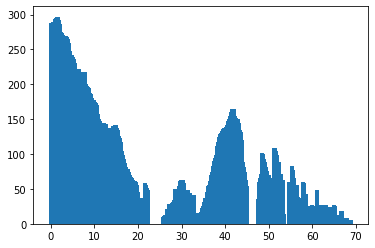

↓ 内径r_i = 1600 外径r = 2000


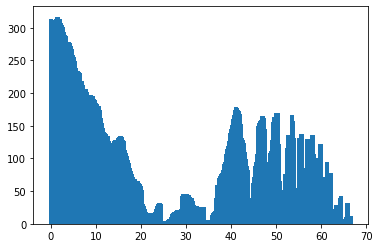

↓ 内径r_i = 1700 外径r = 2000


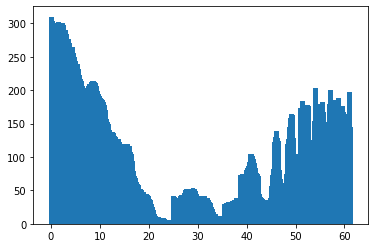

↓ 内径r_i = 1800 外径r = 2000


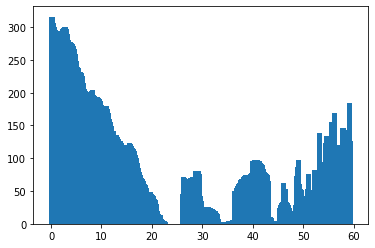

↓ 内径r_i = 1900 外径r = 2000


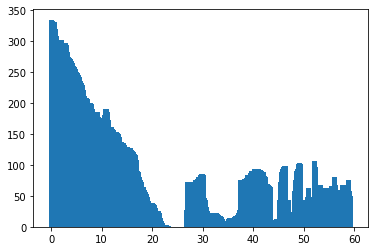

↓ 内径r_i = 200 外径r = 4000


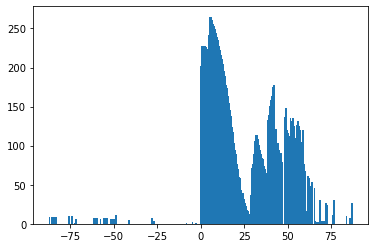

↓ 内径r_i = 400 外径r = 4000


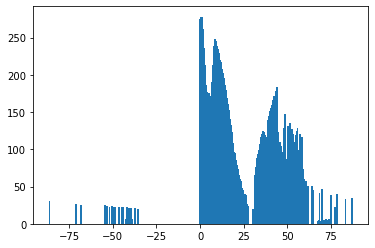

↓ 内径r_i = 600 外径r = 4000


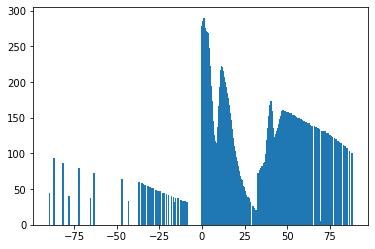

↓ 内径r_i = 800 外径r = 4000


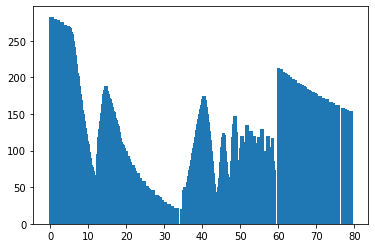

↓ 内径r_i = 1000 外径r = 4000


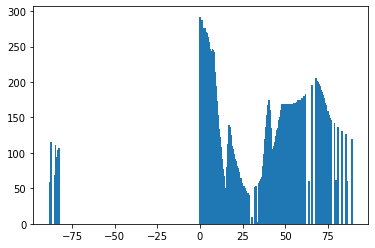

↓ 内径r_i = 1200 外径r = 4000


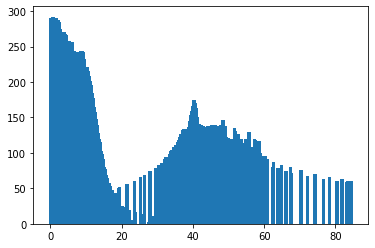

↓ 内径r_i = 1400 外径r = 4000


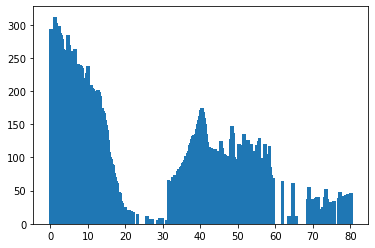

↓ 内径r_i = 1600 外径r = 4000


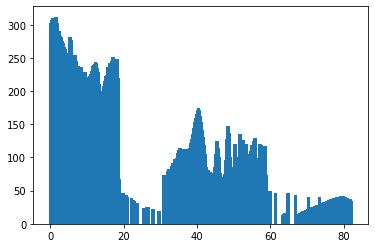

↓ 内径r_i = 1800 外径r = 4000


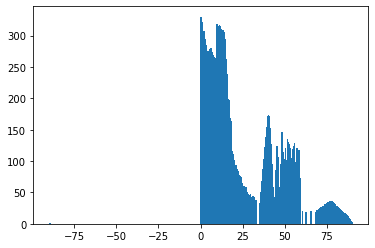

↓ 内径r_i = 2000 外径r = 4000


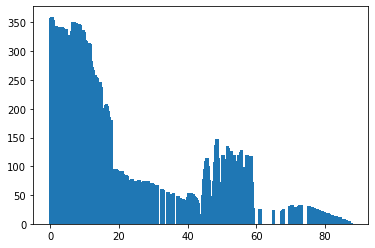

↓ 内径r_i = 2200 外径r = 4000


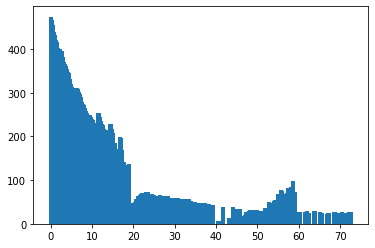

↓ 内径r_i = 2400 外径r = 4000


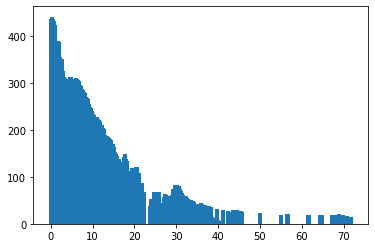

↓ 内径r_i = 2600 外径r = 4000


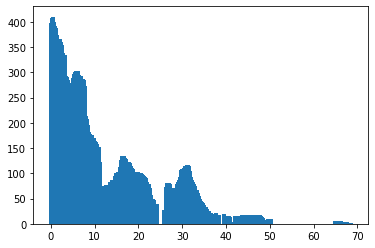

↓ 内径r_i = 2800 外径r = 4000


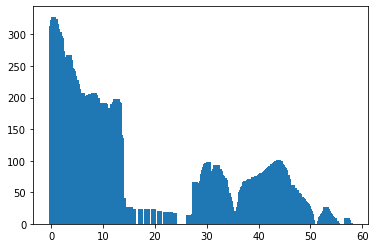

↓ 内径r_i = 3000 外径r = 4000


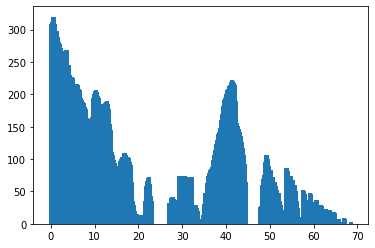

↓ 内径r_i = 3200 外径r = 4000


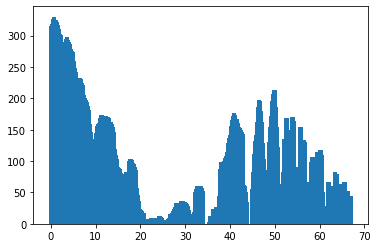

↓ 内径r_i = 3400 外径r = 4000


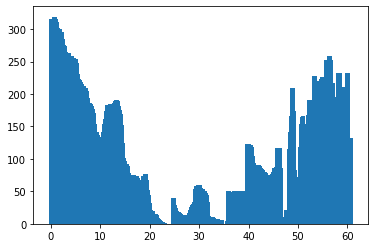

↓ 内径r_i = 3600 外径r = 4000


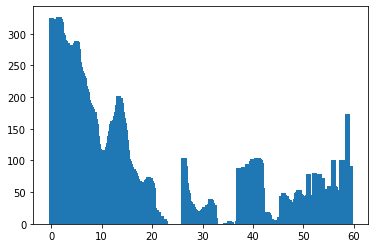

↓ 内径r_i = 3800 外径r = 4000


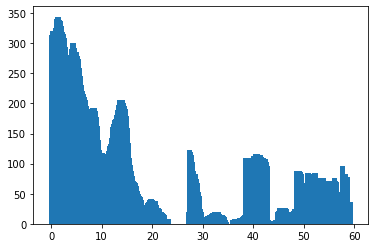

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np

#need to change
max_step = 3000
for step in range(1000, max_step, 1000):
    for threshold in [tmp*0.05 for tmp in range(1, 20)]:
        r = step
        r_i = step*threshold
        r_i = round(r_i)
        #1mm → 10000  0.2mm → 2000 0.05mm → 500
        d1 = r*1.1
        d2 = d1*1.1
        #スリット幅
        s1 = 2000
        s2 = 500
        #複数のCSVファイルを順次読み込んでグラフを表示していく
        df = pd.read_csv('./data_csv/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
        new_x_a_list = df['x'] 
        new_y_a_list = df['y']
        gradient_list = df['gradient']
        intercept_list = df['intercept']
        light_num, toka_angle = light_receiving(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2)
        print('↓ 内径r_i = {0}mm 外径r = {1}mm'.format(r_i*2/10000, r*2/10000))
        plt.xlim([0,90])
        plt.bar(toka_angle, light_num, width=1.0)
        plt.show()